In [33]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob


In [34]:
image = cv2.imread('../images/kitty-cat.jpg', 0)
#image = cv2.imread('../images/text.png', 0)

In [35]:
from keras.models import Model, Sequential
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, AveragePooling2D, Deconvolution2D
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import keras
K.set_image_dim_ordering('th')

In [36]:
from keras import backend as K
from keras.engine.topology import Layer

class SubSampleLayer(Layer):
    def __init__(self, factor=8, **kwargs):
        self.factor = factor
        super(SubSampleLayer, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return x[:,:,::self.factor,::self.factor]

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2]//self.factor, input_shape[3]//self.factor)
    
class QuantizationLayer(Layer):
    def __init__(self, Q=None, unquantization=False, quality_factor=50, **kwargs):
        self.Q = Q
        self.unquantization = unquantization
        self.quality_factor = quality_factor

        
        super(QuantizationLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        if self.Q is None:
            Tb = np.array([16,11,10,16,24,40,51,61,
                           12,12,14,19,26,57,60,55,
                           14,13,16,24,40,57,69,56,
                           14,17,22,29,51,87,80,62,
                           18,22,37,56,68,109,103,77,
                           24,35,55,64,81,104,113,92,
                           49,64,78,87,103,121,120,101,
                           72,92,95,98,112,100,103,99])
            
            if self.quality_factor<50:
                S = 5000/self.quality_factor
            else:
                S = 200 - 2*self.quality_factor
                
            Ts = np.floor((S*Tb+50) / 100).astype(np.float32)
            Ts = Ts[:, np.newaxis, np.newaxis]
            
            self.Q = K.repeat_elements(K.repeat_elements(
                K.variable(value=
                    Ts, dtype='float32'), input_shape[2], 1), input_shape[3], 2)
            
            print "Created", self.quality_factor

        
        super(QuantizationLayer, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, mask=None):
        if self.unquantization:
            return x*self.Q
        else:
            return K.round((x)/self.Q)
        
    def get_output_shape_for(self, input_shape):
        return input_shape
    


In [37]:
#Tb = np.array([16,11,10,16,24,40,51,61,12,12,14,19,26,57,60,55,14,13,16,24,40,57,69,56,14,17,22,29,51,87,80,62,
#              18,22,37,56,68,109,103,77,24,35,55,64,81,104,113,92,49,64,78,87,103,121,120,101,72,92,95,98,112,100,103,99])

#qf = 1

#if qf<50:
#    S = 5000/qf
#else:
#    S = 200 - 2*qf
#
#Ts = np.floor((S*Tb+50) / 100).astype(np.float32)

#print Ts.reshape(8,8)
#Ts = Ts[:, np.newaxis, np.newaxis]

In [38]:
#plt.imshow(im, cmap='gray', interpolation='nearest')
#plt.show()

#flat_image = im.flatten()
#coeff = np.matmul(dct_w, flat_image)

#print coeff.shape
#plt.imshow(coeff.reshape(8,8), cmap='gray', interpolation='nearest')
#plt.show()

#y = np.matmul(dct_w.T, coeff)
#plt.imshow(y.reshape(8,8), cmap='gray', interpolation='nearest')
#plt.show()


IN_SIZE=1024

def onehot_weights():
    patcher_weights = np.zeros((64,1,8,8), dtype=np.float32)
    for x in range(64):
        patcher_weights[x, 0, 7-x//8, 7-x%8] = 1.
        
    return patcher_weights
        
import itertools
import scipy.fftpack
import scipy.ndimage
        
def dct(N=8):
    dct_matrix = np.zeros((N,N), dtype=np.float64)
    for i, j in itertools.product(range(N), range(N)):
        val = 0
        if i == 0:
            val = 1/np.sqrt(N)
        else:
            val = np.sqrt(2/N)*np.cos(  (np.pi*(2*j+1)*i)/(2*N) ) 
            
        dct_matrix[i,j] = val
        
    return dct_matrix
        
def dct_weights():
    return np.kron(dct(),dct()).astype(np.float32)

R = 8

def dct_layer(in_layer):
    patcher = Convolution2D(64, 8, 8, border_mode='valid', 
                            weights=[onehot_weights()], 
                            trainable=False,
                            subsample=(8//R,8//R), bias=False)(in_layer)
    dct_l = Convolution2D(64, 1, 1, border_mode='same', 
                            weights = [np.expand_dims(np.expand_dims(dct_weights(), 2),2)],
                            trainable=False,
                            bias=False)(patcher)
    
    
    quant = QuantizationLayer(quality_factor=5)(dct_l)
    unquant = QuantizationLayer(unquantization=True, quality_factor=5)(quant)
    
    pooly = SubSampleLayer(R)(unquant)
    
    dcti_l = Convolution2D(64, 1, 1, border_mode='same', 
                            weights = [np.expand_dims(np.expand_dims(dct_weights().T, 2),2)],
                            trainable=False,
                            bias=False)(pooly)
    
    #pooly = AveragePooling2D((8,8))(unquant)
    unpatcher = keras.layers.Deconvolution2D(1, 8, 8,
                            output_shape=(None,1,IN_SIZE,IN_SIZE), subsample=(8,8), border_mode='valid', 
                            weights=[onehot_weights().transpose(1,0,2,3)], 
                            trainable=False, bias=False)(dcti_l)
    
    
    return unpatcher 


def o():
    In = 128
    
    model = Sequential()
    model.add(Convolution2D(64, 8, 8, border_mode='valid', 
                            input_shape=(1,In,In),
                            weights=[onehot_weights()], 
                            trainable=False,
                            subsample=(8//R,8//R), bias=False))
    
    model.add(SubSampleLayer())
    
    model.add(QuantizationLayer(quantization_matrix, False, quality_factor=5))
    model.add(QuantizationLayer(quantization_matrix, True, quality_factor=5))
    
    model.add(Deconvolution2D(1,8,8, 
                                border_mode='valid', 
                                output_shape=(None,1,In,In),
                                weights=[onehot_weights().transpose(1,0,2,3)], 
                                bias=False,
                                subsample=(8,8)))
    
    dummy = np.arange(In*In).reshape(1,1,In,In)
    plt.imshow(dummy[0,0], interpolation='nearest')
    plt.show()
    p = model.predict(dummy)
    #print p[0]
    plt.imshow(p[0,0], interpolation='nearest')
    print p[0].shape
    print p[0]
#o()



im = (image.astype(np.float32)-128)[100:100+IN_SIZE,100:100+IN_SIZE]





In [39]:
inputs = Input((1, IN_SIZE, IN_SIZE))
x = dct_layer(inputs)
m = Model(input=inputs, output=x)
m.compile(loss='mean_squared_error', optimizer='sgd')
out = m.predict(np.array([[im]], dtype=np.float32))
print out.shape

Created 5
Created 5
(1L, 1L, 1024L, 1024L)


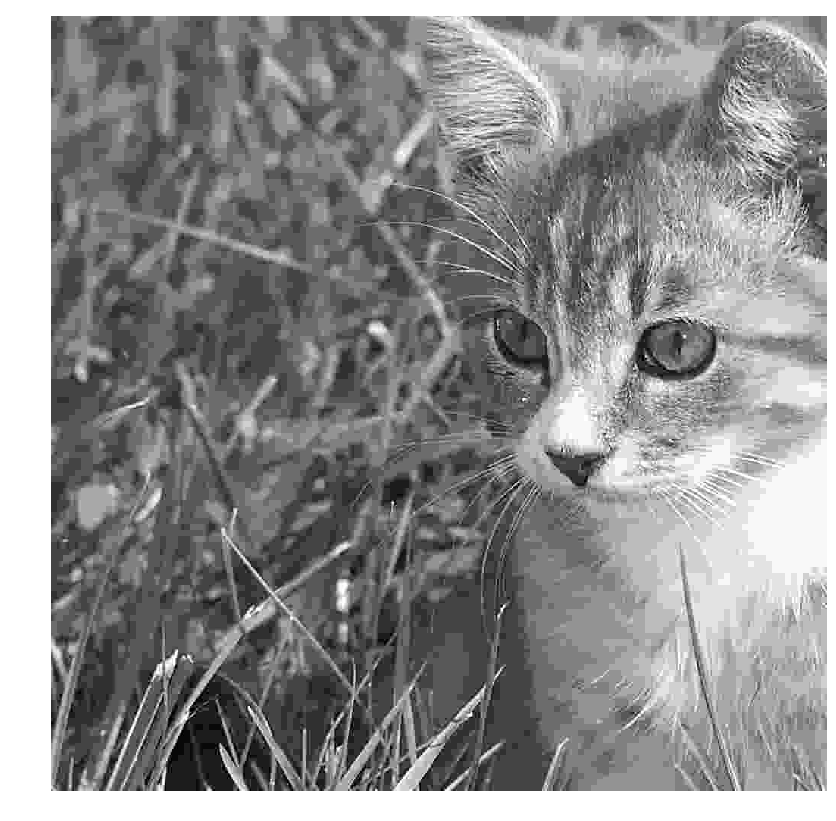

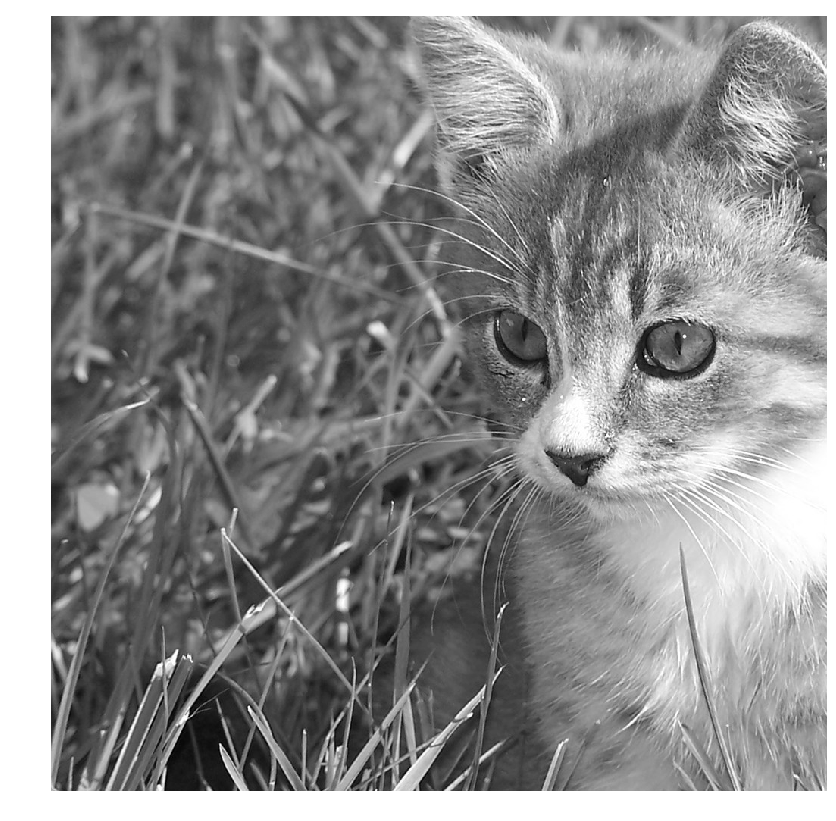

[[  88.   88.   88. ...,  128.  128.  128.]
 [  88.   88.   88. ...,  128.  128.  128.]
 [  88.   88.   88. ...,  128.  128.  128.]
 ..., 
 [ 176.  181.  186. ...,  190.  175.  177.]
 [ 140.  156.  178. ...,  199.  179.  176.]
 [ 117.  139.  171. ...,  203.  180.  176.]]
[[  74.   74.   77. ...,  122.  121.  121.]
 [  74.   74.   77. ...,  123.  122.  122.]
 [  73.   74.   77. ...,  124.  122.  123.]
 ..., 
 [ 163.  181.  193. ...,  171.  184.  185.]
 [ 169.  173.  174. ...,  178.  190.  192.]
 [ 178.  182.  167. ...,  188.  197.  199.]]


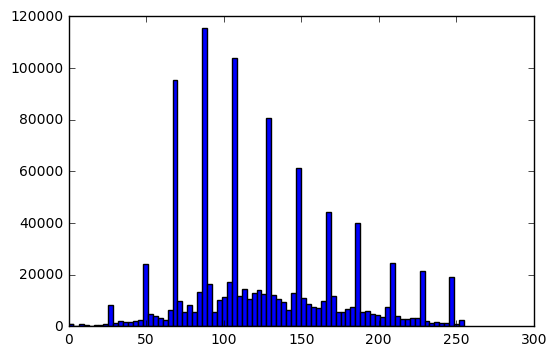

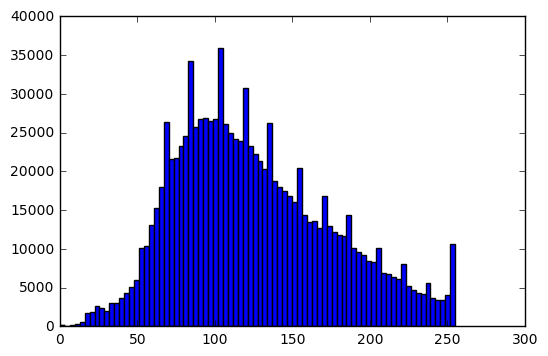

In [40]:
p_im1 = np.clip(np.round((out[0,0,:,:]+128)), 0, 255)
p_im2 = (im+128)


plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(p_im1, cmap='gray', interpolation='nearest')
plt.show()
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(p_im2, cmap='gray', interpolation='nearest')
plt.show()
#plt.imshow(coeff.reshape(8,8), cmap='gray', interpolation='nearest')
#plt.show()

plt.imsave('../images/textout.png', p_im1, cmap='gray')

print p_im1
print p_im2


plt.hist(p_im1.flatten(),80)
plt.show()
plt.hist(p_im2.flatten(),80)
plt.show()

#plt.imshow(im)
#plt.imshow((out[0,:,0,0]- coeff).reshape(8,8))
